# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True


In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"


In [4]:
import sys
sys.path.append('../')


In [20]:
import neptune


In [21]:
## download from neptune
LOC_START_ID, LOC_END_ID = 1799, 1963
LOC_SKIP_IDS = []
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]


In [22]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")


In [23]:
def fetch_metadata(run_id: str, granularity: str = "cg") -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}, RUN_ID: {run_id}"

        match granularity:
            case "cg":
                metric = run["scores"]["metric"].fetch()
                ac2 = metric["AC_2_mand"]
                ac5 = metric["AC_5_mand"]
                avg5 = metric["AVG_5_mand"]
                elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
                return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                            "reduction_method": reduction, "localization_method": localization,
                            "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}
            case "fg":
                path = f"/tmp/score-df-by-cause-comp-and-type-{run_id}.html"
                run["eval/score-df-by-cause-comp-and-type"].download(path)
                df = pd.concat(pd.read_html(path), axis=1)
                df.rename(
                    columns={
                        "Unnamed: 0": "dataset_id", "Unnamed: 1": "target_app", "Unnamed: 2": "chaos_comp", "Unnamed: 3": "chaos_type", "Unnamed: 4": "top_k"},
                    inplace=True,
                )

                path2 = f"/tmp/elapsed-time-df-by-cause-comp-and-type-{run_id}.html"
                run["elapsed_time/mean_by_chaos_type_and_chaos_comp"].download(path2)
                df2 = pd.concat(pd.read_html(path2), axis=1)
                df2.columns = df2.columns.set_levels(["chaos_type", "chaos_comp", "elapsed_time"], level=0)
                df2.columns = df2.columns.droplevel(1)
                elapsed_times = df2.set_index(["chaos_type", "chaos_comp"]).to_dict()["elapsed_time"]

                items = []
                for name, group in df.groupby(
                    ["dataset_id", "target_app", "chaos_comp", "chaos_type"], as_index=False,
                ):
                    ac_2 = group.loc[group["top_k"] == 2, "AC@K (metric) (mandatory)"].values[0]
                    ac_5 = group.loc[group["top_k"] == 5, "AC@K (metric) (mandatory)"].values[0]
                    avg_5 = group.loc[group["top_k"] == 5, "AVG@K (metric) (mandatory)"].values[0]
                    chaos_type = group["chaos_type"].iat[0]
                    chaos_comp = group["chaos_comp"].iat[0]
                    elapsed_time = elapsed_times[(chaos_type, chaos_comp)]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(group["target_app"].iat[0], middleware, manually_selected),
                        "reduction_method": reduction, "localization_method": localization,
                        "chaos_comp": chaos_comp, "chaos_type": chaos_type,
                        "ac@2": ac_2, "ac@5": ac_5, "avg@5": avg_5, "elapsed_time": elapsed_time,
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granularity}"


In [24]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run, granularity="fg") for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
items = sum(items, [])
# assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1801
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1831
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1816
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1808
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1817
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1803
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1799
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1838
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1807
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1815
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1829
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1802
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1828
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1804
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1835
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1818
https://

In [25]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    _loc_df = loc_tsdr_df.sort_values(["run_id", "dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], ascending=False).drop_duplicates(subset=["dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], keep="first")
    display(
        _loc_df.groupby(["dataset", "reduction_method", "localization_method"])[["ac@2", "ac@5", "avg@5", "elapsed_time"]].agg("mean")
    )


ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            RCD                  0.106250  0.130000  0.122875   
          FluxInfer-AD     RCD                  0.125000  0.130000  0.126833   
          HDBS-R           RCD                  0.118750  0.070833  0.093333   
          HDBS-SBD         RCD                  0.100000  0.075833  0.083500   
          K-S test         RCD                  0.131250  0.130833  0.126792   
          MetricSifter     RCD                  0.112500  0.153333  0.128375   
          NSigma           RCD                  0.106250  0.141667  0.119583   
          None             RCD                  0.087500  0.137500  0.113125   
SS-medium BIRCH            CG+PageRank          0.006250  0.012500  0.010417   
                           RCD                  0.331250  0.392500  0.343708   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.018750  0.016667  0.015417   
                           RCD                  0.312500  0.362500  0.328333   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          HDBS-R           CG+PageRank          0.012500  0.024167  0.012958   
                           RCD                  0.212500  0.198333  0.220917   
                           e-Diagnosis          0.006250  0.022500  0.012625   
          HDBS-SBD         CG+PageRank          0.025000  0.037500  0.029375   
                           RCD                  0.312500  0.222500  0.258458   
                           e-Diagnosis          0.000000  0.022500  0.012208   
          K-S test         CG+PageRank          0.012500  0.012500  0.011042   
                           RCD                  0.331250  0.360000  0.338458   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          MetricSifter     CG+PageRank          0.021875  0.038125  0.031948   
                           RCD                  0.368750  0.461667  0.393583   
                           e-Diagnosis          0.018750  0.040625  0.028542   
          NSigma           CG+PageRank          0.025000  0.024167  0.021708   
                           RCD                  0.300000  0.396667  0.339958   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          None             CG+PageRank          0.018750  0.029167  0.025208   
                           RCD                  0.300000  0.368333  0.325125   
                           e-Diagnosis          0.000000  0.000000  0.000000   
SS-small  BIRCH            CG+PageRank          0.050000  0.039167  0.040750   
                           LiNGAM+HT            0.162500  0.152500  0.163000   
                           LiNGAM+PageRank      0.137500  0.108333  0.131667   
                           PC+HT                0.231250  0.172500  0.204917   
                           PC+PageRank          0.081250  0.081667  0.086958   
                           RCD                  0.306250  0.226667  0.263250   
                           e-Diagnosis          0.031250  0.025000  0.030208   
          FluxInfer-AD     CG+PageRank          0.025000  0.028333  0.028375   
                           LiNGAM+HT            0.193750  0.169167  0.186333   
                           LiNGAM+PageRank      0.131250  0.112500  0.126250   
                           PC+HT                0.212500  0.174167  0.203375   
                           PC+PageRank          0.068750  0.070833  0.074375   
                           RCD                  0.300000  0.236667  0.279625   
                           e-Diagnosis          0.037500  0.031667  0.032792   
          HDBS-R           CG+PageRank          0.025000  0.033333  0.021667   
                           LiNGAM+HT            0.150000  0.101667  0.137000   
                           LiNGAM+PageRank      0.10

## Load tsdr

In [26]:
TSDR_START_ID, TSDR_END_ID = 1765, 1835
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]


In [27]:
def fetch_metadata_of_tsdr(run_id: str, granurality: str = "cg") -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        try:
            dataset = run["dataset"].fetch()
            target_app = dataset["target_app"]
            middleware = dataset["metric_types"]["middlewares"]
            manually_selected = dataset["use_manually_selected_metrics"]
        except neptune.exceptions.MissingFieldException:
            return {}

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        try:
            scores = run["scores"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}
        try:
            _ = run["scores/cause_metrics"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}

        match granurality:
            case "cg":
                tp = scores["cause_metrics"]["tp_mean"]
                tn = scores["cause_metrics"]["tn_mean"]
                fn = scores["cause_metrics"]["fn_mean"]
                fp = scores["cause_metrics"]["fp_mean"]
                recall = scores["cause_metrics"]["recall_mandatory_mean"]
                specificity = scores["cause_metrics"]["specificity_mean"]
                frr = scores["reduction_rate_mean"]
                proportion = scores["cause_metrics"]["proportion_mandatory_mean"]
                f1_score = scores["cause_metrics"]["f1_score_mean"]
                mcc = scores["cause_metrics"]["mcc_mean"]
                bacc = scores["cause_metrics"]["bacc_mean"]

                num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
                num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
                elapsed_time = scores["elapsed_time"]
                return {
                    "run_id": run_id,
                    "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction,
                    "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                    "specificity": specificity, "recall": recall, "proportion": proportion,
                    "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                    "reduction_rate": frr,
                    "elapsed_time": elapsed_time,
                    "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                    "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
                }
            case "fg":
                csv_path = f"/tmp/summary_by_chaos_type_and_chaos_comp-{run_id}.csv"
                run["scores/summary_by_chaos_type_and_chaos_comp-csv"].download(csv_path)
                df = pd.read_csv(csv_path)
                last_phase = df["phase"].drop_duplicates().sort_values().iat[-1]
                df = df[df["phase"] == last_phase].set_index(["chaos_type", "chaos_comp", "phase"]).sort_index()
                items = []
                for index, row in df.iterrows():
                    tp = row["cause_metrics/tp_mean"]
                    tn = row["cause_metrics/tn_mean"]
                    fn = row["cause_metrics/fn_mean"]
                    fp = row["cause_metrics/fp_mean"]
                    recall = row["cause_metrics/recall_mandatory_mean"]
                    specificity = row["cause_metrics/specificity_mean"]
                    frr = row["reduction_rate_mean"]
                    proportion = row["cause_metrics/proportion_mandatory_mean"]
                    f1_score = row["cause_metrics/f1_score_mean"]
                    mcc = row["cause_metrics/mcc_mean"]
                    bacc = row["cause_metrics/bacc_mean"]

                    num_series = tuple([int (s) for s in row["num_series/total"].split("/")])
                    num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]
                    elapsed_time = row["elapsed_time"]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                        "reduction_method": reduction,
                        "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                        "specificity": specificity, "recall": recall, "proportion": proportion,
                        "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                        "reduction_rate": frr,
                        "elapsed_time": elapsed_time,
                        "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                        "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
                        "chaos_type": index[0], "chaos_comp": index[1],
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granurality}"


In [28]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="cg") for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1765
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1772
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1770
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1777
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1781
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1779
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1784
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1783
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1780
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1787
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1782
https://app.neptune.ai/yuuk1/tsdr/

In [29]:
tsdr_fg_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="fg") for run in TSDR_RUN_IDS)
assert tsdr_fg_items is not None
tsdr_fg_items = [item for item in tsdr_fg_items if item]
tsdr_fg_items = sum(tsdr_fg_items, [])
# assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1765
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1770
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1772
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1777
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1779
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1781
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1780
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1783
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1785
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1782
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1784
https://app.neptune.ai/yuuk1/tsdr/

In [30]:
def create_table_dataframe_multi_level(
    items: list[dict[str, str|float]],
    first_levels: list[str], second_levels: list[str], first_level_key: str, second_level_key: str, first_label: str, second_label: str,
    columns: list[str],
) -> pd.DataFrame:
    multi_level_indexes = pd.MultiIndex.from_product(
        [first_levels, second_levels], names=[first_label, second_label])
    multi_level_cols = pd.MultiIndex.from_product([first_levels, columns], names=['', ''])
    items_df = pd.DataFrame(items).drop_duplicates(subset=[first_level_key, second_level_key], keep="last")
    df = items_df.set_index([first_level_key, second_level_key]).reindex(index=multi_level_indexes)
    df = df.unstack(first_label)
    df = df.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=second_levels, columns=multi_level_cols,
    )
    return df

from itertools import product

def to_latex_table(table_df: pd.DataFrame, first_levels: list[str], second_levels: list[str], columns: list[str], highlight_max_columns: list[str], highlight_min_columns: list[str]) -> str:
    styler = table_df[product(first_levels, columns)].style
    styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
    styler.format({k: '{:.4f}' for k in product(first_levels, ["bacc"])}, precision=3)
    return styler.to_latex(hrules=True)


In [31]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBS-SBD", "HDBS-R", "MetricSifter"]
metrics = ["specificity", "recall", "bacc", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets


In [32]:
tsdr_df = pd.DataFrame(tsdr_items)


In [33]:
ss_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=ss_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ss_table_df)

print(
    to_latex_table(ss_table_df, ss_datasets, reduction_methods, metrics, ["specificity", "recall", "bacc"], ["elapsed_time"])
)


SS-small                                  SS-medium  \
                 specificity  recall      bacc elapsed_time specificity   
Reduction Method                                                          
None                0.000000  1.0000  0.500000     0.308875    0.000000   
NSigma              0.131433  0.9875  0.559467     0.572220    0.179406   
BIRCH               0.159496  1.0000  0.579748     0.375484    0.186424   
K-S test            0.132051  1.0000  0.566025     0.588056    0.136913   
FluxInfer-AD        0.132051  1.0000  0.566025     0.596905    0.136913   
HDBS-SBD            0.456835  0.4375  0.447168     0.666308    0.688493   
HDBS-R              0.457668  0.4500  0.453834     0.673615    0.692877   
MetricSifter        0.346632  0.9750  0.660816     1.839095    0.457919   

                                                     SS-large            \
                    recall      bacc elapsed_time specificity    recall   
Reduction Method                                                          
None              1.000000  0.500000     0.312021    0.000000  1.000000   
NSigma            0.987500  0.583453     0.620755    0.319145  0.962538   
BIRCH             1.000000  0.593212     0.419534    0.241884  0.976174   
K-S test          1.000000  0.568456     0.640145    0.119315  0.996875   
FluxInfer-AD      1.000000  0.568456     0.646770    0.119315  0.996875   
HDBS-SBD          0.254375  0.471434     0.758412    0.843117  0.135164   
HDBS-R            0.229375  0.461126     0.989142    0.835870  0.137156   
MetricSifter      0.979167  0.718543     3.500554    0.493700  0.941810   

                                         
                      bacc elapsed_time  
Reduction Method                         
None              0.500000     0.450160  
NSigma            0.640842     1.139934  
BIRCH             0.609029     0.942817  
K-S test          0.558095     1.193169  
FluxInfer-AD      0.558095     1.197870  
HDBS-SBD          0.489140     6.486058  
HDBS-R            0.486513    81.353077  
MetricSifter      0.717755    18.172811

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & specificity & recall & bacc & elapsed_time & specificity & recall & bacc & elapsed_time & specificity & recall & bacc & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.5000 & \textbf{0.309} & 0.000 & \textbf{1.000} & 0.5000 & \textbf{0.312} & 0.000 & \textbf{1.000} & 0.5000 & \textbf{0.450} \\
NSigma & 0.131 & 0.988 & 0.5595 & 0.572 & 0.179 & 0.988 & 0.5835 & 0.621 & 0.319 & 0.963 & 0.6408 & 1.140 \\
BIRCH & 0.159 & \textbf{1.000} & 0.5797 & 0.375 & 0.186 & \textbf{1.000} & 0.5932 & 0.420 & 0.242 & 0.976 & 0.6090 & 0.943 \\
K-S test & 0.132 & \textbf{1.000} & 0.5660 & 0.588 & 0.137 & \textbf{1.000} & 0.5685 & 0.640 & 0.119 & 0.997 & 0.5581 & 1.193 \\
FluxInfer-AD & 0.132 & \textbf{1.000} & 0.5660 & 0.597 & 0.137 & \textbf{1.000} & 0.5685 & 0.647 & 0.119 & 0.997 & 0.5581 & 1.198 \\


In [34]:
tt_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=tt_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(tt_table_df)

print(
    to_latex_table(tt_table_df, tt_datasets, reduction_methods, metrics, ["specificity", "recall", "bacc"], ["elapsed_time"])
)


TT-small                                    TT-medium  \
                 specificity    recall      bacc elapsed_time specificity   
Reduction Method                                                            
None                0.000000  1.000000  0.500000     0.487493    0.000000   
NSigma              0.292287  1.000000  0.646144     1.137826    0.329683   
BIRCH               0.268137  0.976190  0.622164     0.719648    0.272097   
K-S test            0.279064  1.000000  0.639532     1.173876    0.265505   
FluxInfer-AD        0.279064  1.000000  0.639532     1.177455    0.265505   
HDBS-SBD            0.524429  0.500000  0.512214     1.416407    0.742747   
HDBS-R              0.527141  0.619048  0.573095     1.652402    0.741985   
MetricSifter        0.548077  0.904762  0.726419     6.242236    0.655040   

                                                     TT-large            \
                    recall      bacc elapsed_time specificity    recall   
Reduction Method                                                          
None              1.000000  0.500000     0.580712    0.000000  1.000000   
NSigma            1.000000  0.664841     1.492505    0.468218  0.989087   
BIRCH             1.000000  0.636049     1.097160    0.354604  0.992063   
K-S test          1.000000  0.632753     1.565933    0.243313  0.996032   
FluxInfer-AD      1.000000  0.632753     1.572307    0.243313  0.996032   
HDBS-SBD          0.177778  0.460263     2.223186    0.854100  0.131661   
HDBS-R            0.185714  0.463849     3.091267         NaN       NaN   
MetricSifter      0.948413  0.801726    18.558376    0.650948  0.849773   

                                         
                      bacc elapsed_time  
Reduction Method                         
None              0.500000     1.604450  
NSigma            0.728653     5.019302  
BIRCH             0.673334     4.679712  
K-S test          0.619672     5.337064  
FluxInfer-AD      0.619672     5.358660  
HDBS-SBD          0.492880    14.706824  
HDBS-R                 NaN          NaN  
MetricSifter      0.750361   114.706210

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & specificity & recall & bacc & elapsed_time & specificity & recall & bacc & elapsed_time & specificity & recall & bacc & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.5000 & \textbf{0.487} & 0.000 & \textbf{1.000} & 0.5000 & \textbf{0.581} & 0.000 & \textbf{1.000} & 0.5000 & \textbf{1.604} \\
NSigma & 0.292 & \textbf{1.000} & 0.6461 & 1.138 & 0.330 & \textbf{1.000} & 0.6648 & 1.493 & 0.468 & 0.989 & 0.7287 & 5.019 \\
BIRCH & 0.268 & 0.976 & 0.6222 & 0.720 & 0.272 & \textbf{1.000} & 0.6360 & 1.097 & 0.355 & 0.992 & 0.6733 & 4.680 \\
K-S test & 0.279 & \textbf{1.000} & 0.6395 & 1.174 & 0.266 & \textbf{1.000} & 0.6328 & 1.566 & 0.243 & 0.996 & 0.6197 & 5.337 \\
FluxInfer-AD & 0.279 & \textbf{1.000} & 0.6395 & 1.177 & 0.266 & \textbf{1.000} & 0.6328 & 1.572 & 0.243 & 0.996 & 0.6197 & 

## Join tsdr and localization

In [35]:
import itertools

tsdr_fg_df = pd.DataFrame(tsdr_fg_items) # .set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"])
loc_rs_df = pd.DataFrame(
    {
        "dataset": row["dataset"], "localization_method": "RS", "reduction_method": row["reduction_method"],
        "ac@2": row["rs_ac@2"], "ac@5": row["rs_ac@5"], "avg@5": row["rs_avg@5"], "chaos_type": row["chaos_type"], "chaos_comp": row["chaos_comp"],
    } for _, row in tsdr_fg_df.iterrows()
)
loc_rs_df


,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5,chaos_type,chaos_comp
0,SS-small,RS,MetricSifter,0.078829,0.185049,0.114212,pod-cpu-hog,carts
1,SS-small,RS,MetricSifter,0.046543,0.112298,0.068457,pod-cpu-hog,carts-db
2,SS-small,RS,MetricSifter,0.068039,0.161374,0.099137,pod-cpu-hog,catalogue
3,SS-small,RS,MetricSifter,0.070111,0.166114,0.102097,pod-cpu-hog,catalogue-db
4,SS-small,RS,MetricSifter,0.039003,0.094672,0.057557,pod-cpu-hog,orders
...,...,...,...,...,...,...,...,...
1037,TT-medium,RS,HDBS-R,0.001849,0.004604,0.002768,pod-memory-hog,ts-order-service
1038,TT-medium,RS,HDBS-R,0.005995,0.014869,0.008953,pod-memory-hog,ts-station-service
1039,TT-medium,RS,HDBS-R,0.006178,0.015373,0.009243,pod-memory-hog,ts-train-service
1040,TT-medium,RS,HDBS-R,0.013577,0.033598,0.020251,pod-memory-hog,ts-travel-service


In [48]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df], axis=0)

joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_fg_df.set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"]), how="outer", on=['dataset', 'reduction_method', 'chaos_type', 'chaos_comp'],
    lsuffix='_loc', rsuffix='_tsdr',
)
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
aggregated_joined_df = joined_df.loc[:, ~joined_df.columns.isin(['run_id', 'run_id_tsdr', 'run_id_loc', 'chaos_comp', 'chaos_type'])].reset_index().groupby(['dataset', 'localization_method', 'reduction_method'], as_index=True).agg("mean").sort_index().loc[:, ["ac@2", "ac@5", "avg@5", "elapsed_time_sum", "elapsed_time_tsdr", "elapsed_time_loc", "bacc", "recall", "mcc", "specificity", "f1_score"]]
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
    display(
        # joined_df.reset_index().set_index(["dataset", "localization_method", "reduction_method"])
        aggregated_joined_df
    )


ac@2   ac@5  avg@5  \
dataset   localization_method reduction_method                        
SS-large  RCD                 BIRCH            0.1062 0.1300 0.1229   
                              FluxInfer-AD     0.1250 0.1300 0.1268   
                              HDBS-R           0.1188 0.0708 0.0933   
                              HDBS-SBD         0.1000 0.0758 0.0835   
                              K-S test         0.1313 0.1308 0.1268   
                              MetricSifter     0.1062 0.1396 0.1217   
                              NSigma           0.1062 0.1417 0.1196   
                              None             0.0875 0.1375 0.1131   
          RS                  BIRCH            0.0127 0.0314 0.0190   
                              FluxInfer-AD     0.0113 0.0280 0.0168   
                              HDBS-R           0.0075 0.0186 0.0112   
                              HDBS-SBD         0.0079 0.0196 0.0118   
                              K-S test         0.0113 0.0280 0.0168   
                              MetricSifter     0.0185 0.0456 0.0276   
                              NSigma           0.0139 0.0343 0.0207   
                              None             0.0100 0.0248 0.0150   
SS-medium CG+PageRank         BIRCH            0.0063 0.0125 0.0104   
                              FluxInfer-AD     0.0188 0.0167 0.0154   
                              HDBS-R           0.0125 0.0242 0.0130   
                              HDBS-SBD         0.0250 0.0375 0.0294   
                              K-S test         0.0125 0.0125 0.0110   
                              MetricSifter     0.0219 0.0381 0.0319   
                              NSigma           0.0250 0.0242 0.0217   
                              None             0.0188 0.0292 0.0252   
          RCD                 BIRCH            0.3312 0.3925 0.3437   
                              FluxInfer-AD     0.3125 0.3625 0.3283   
                              HDBS-R           0.2125 0.1983 0.2209   
                              HDBS-SBD         0.3125 0.2225 0.2585   
                              K-S test         0.3312 0.3600 0.3385   
                              MetricSifter     0.3695 0.4380 0.3859   
                              NSigma           0.3000 0.3967 0.3400   
                              None             0.3000 0.3683 0.3251   
          RS                  BIRCH            0.0575 0.1369 0.0839   
                              FluxInfer-AD     0.0543 0.1298 0.0795   
                              HDBS-R           0.0356 0.0860 0.0524   
                              HDBS-SBD         0.0375 0.0902 0.0550   
                              K-S test         0.0543 0.1298 0.0795   
                              MetricSifter     0.0888 0.2049 0.1274   
                              NSigma           0.0559 0.1335 0.0818   
                              None             0.0472 0.1133 0.0692   
          e-Diagnosis         BIRCH            0.0000 0.0000 0.0000   
                              FluxInfer-AD     0.0000 0.0025 0.0005   
                              HDBS-R           0.0063 0.0225 0.0126   
                              HDBS-SBD         0.0000 0.0225 0.0122   
                              K-S test         0.0000 0.0025 0.0005   
                              MetricSifter     0.0188 0.0406 0.0285   
                              NSigma           0.0000 0.0025 0.0005   
                              None             0.0000 0.0000 0.0000   
SS-small  CG+PageRank         BIRCH            0.0500 0.0392 0.0408   
                              FluxInfer-AD     0.0250 0.0283 0.0284   
                              HDBS-R           0.0250 0.0333 0.0217   
                              HDBS-SBD         0.0312 0.0408 0.0296   
                              K-S test         0.0250 0.0292 0.0267   
                              MetricSifter     0.0823 0.0790 0.0784   
                              NSigma           0.0375 0.0392 0.0405   
  

In [134]:
joined_df.to_csv("materials/joined_df.csv")
aggregated_joined_df.to_csv("materials/aggregated_joined_df.csv")


AttributeError: 'NoneType' object has no attribute 'to_csv'

In [162]:
aggregated_joined_df = pd.read_csv("materials/aggregated_joined_df.csv")
aggregated_joined_df.replace({"reduction_method": np.NAN}, "None", inplace=True)
aggregated_joined_df = aggregated_joined_df.reset_index().drop(index=aggregated_joined_df.reset_index().query("dataset != 'SS-small' & localization_method in ['CG+PageRank', 'e-Diagnosis']").index).drop(columns=["index"])


In [163]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
    display(
        aggregated_joined_df
    )


,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5,elapsed_time_sum,bacc,recall,mcc,specificity,f1_score
0,SS-large,RCD,BIRCH,0.1062,0.1300,0.1229,1743.0168,0.6090,0.9762,0.0342,0.2419,0.0127
1,SS-large,RCD,FluxInfer-AD,0.1250,0.1300,0.1268,2032.2484,0.5581,0.9969,0.0244,0.1193,0.0113
2,SS-large,RCD,HDBS-R,0.1187,0.0708,0.0933,435.3805,0.4857,0.1355,-0.0066,0.8359,0.0073
3,SS-large,RCD,HDBS-SBD,0.1000,0.0758,0.0835,338.4687,0.4891,0.1350,-0.0052,0.8431,0.0077
4,SS-large,RCD,K-S test,0.1313,0.1308,0.1268,2031.0888,0.5581,0.9969,0.0244,0.1193,0.0113
5,SS-large,RCD,MetricSifter,0.1062,0.1396,0.1217,1065.0887,0.7178,0.9418,0.0596,0.4937,0.0184
6,SS-large,RCD,NSigma,0.1062,0.1417,0.1196,1558.7035,0.6408,0.9625,0.0406,0.3191,0.0138
7,SS-large,RCD,None,0.0875,0.1375,0.1131,2222.2877,0.5000,1.0000,-10.0000,0.0000,0.0100
8,SS-large,RS,BIRCH,0.0127,0.0314,0.0190,NaN,0.6090,0.9762,0.0342,0.2419,0.0127
9,SS-large,RS,FluxInfer-AD,0.0113,0.0280,0.0168,NaN,0.5581,0.9969,0.0244,0.1193,0.0113


In [230]:
# 平均増加精度
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).agg(["mean", "max", "min"])


/tmp/ipykernel_2660326/4050754463.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


mean     2.771665
max     16.494259
min     -3.633340
Name: avg@5, dtype: float64

In [229]:
aggregated_joined_df.reset_index().query("localization_method == 'RS'").groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).mean()


/tmp/ipykernel_2660326/1823826774.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


2.054221422161659

In [225]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"] != "MetricSifter"]["avg@5"].max()) * 100
)


dataset    localization_method     
SS-large   RCD                  5     -0.516666
           RS                   13     0.683949
SS-medium  RCD                  21     4.215097
           RS                   29     4.349913
SS-small   CG+PageRank          37     3.763887
           LiNGAM+HT            45    -0.994204
           LiNGAM+PageRank      53    -0.129862
           PC+HT                61     2.099312
           PC+PageRank          69     2.466660
           RCD                  77    -0.507642
           RS                   85     2.028624
           e-Diagnosis          93     0.374306
TT-large   RS                   100    0.122314
TT-medium  RCD                  108   -3.633340
           RS                   116    1.258289
TT-small   RCD                  124    0.341660
           RS                   132    0.533230
Name: avg@5, dtype: float64

In [224]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"] != "MetricSifter"]["avg@5"].max()) * 100
)


dataset    localization_method     
SS-large   RCD                  5     -0.516666
           RS                   13     0.683949
SS-medium  RCD                  21     4.215097
           RS                   29     4.349913
SS-small   CG+PageRank          37     3.763887
           LiNGAM+HT            45    -0.994204
           LiNGAM+PageRank      53    -0.129862
           PC+HT                61     2.099312
           PC+PageRank          69     2.466660
           RCD                  77    -0.507642
           RS                   85     2.028624
           e-Diagnosis          93     0.374306
TT-large   RS                   100    0.122314
TT-medium  RCD                  108   -3.633340
           RS                   116    1.258289
TT-small   RCD                  124    0.341660
           RS                   132    0.533230
Name: avg@5, dtype: float64

In [187]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"] != "MetricSifter"]["avg@5"].max()) * 100
)


dataset    localization_method     
SS-large   RCD                  5     -0.516666
           RS                   13     0.683949
SS-medium  RCD                  21     4.215097
           RS                   29     4.349913
SS-small   CG+PageRank          37     3.763887
           LiNGAM+HT            45    -0.994204
           LiNGAM+PageRank      53    -0.129862
           PC+HT                61     2.099312
           PC+PageRank          69     2.466660
           RCD                  77    -0.507642
           RS                   85     2.028624
           e-Diagnosis          93     0.374306
TT-large   RS                   100    0.122314
TT-medium  RCD                  108   -3.633340
           RS                   116    1.258289
TT-small   RCD                  124    0.341660
           RS                   132    0.533230
Name: avg@5, dtype: float64

In [231]:
# T(s) 平均改善率
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] != "MetricSifter"]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])
).dropna().agg(["mean", "max", "min"])


/tmp/ipykernel_2660326/1813844730.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: x[x["reduction_method"] != "MetricSifter"]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])


mean    1.498671
max     3.660240
min     0.245671
Name: elapsed_time_sum, dtype: float64

In [200]:
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x.iloc[x[x["reduction_method"] != "MetricSifter"]["avg@5"].argmax(), :]["elapsed_time_sum"] / x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]
)


dataset    localization_method     
SS-large   RCD                  5      1.908056
           RS                   13          NaN
SS-medium  RCD                  29     1.916532
           RS                   37          NaN
SS-small   CG+PageRank          53     0.245671
           LiNGAM+HT            61     2.015003
           LiNGAM+PageRank      69     1.974906
           PC+HT                77     1.948229
           PC+PageRank          85     0.253754
           RCD                  93     1.591037
           RS                   101         NaN
           e-Diagnosis          109    1.317601
TT-large   RS                   116         NaN
TT-medium  RCD                  132    1.766622
           RS                   140         NaN
TT-small   RCD                  164    1.330148
           RS                   172         NaN
Name: elapsed_time_sum, dtype: float64

In [233]:
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "None"]["avg@5"] - float(x[x["reduction_method"] == "None"]["avg@5"])) * 100
).agg(["mean", "max", "min"])


/tmp/ipykernel_2660326/581368971.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"] != "None"]["avg@5"] - float(x[x["reduction_method"] == "None"]["avg@5"])) * 100


mean     0.314312
max     10.862512
min     -6.073428
Name: avg@5, dtype: float64

In [285]:
# None 悪化率が悪いケースを抽出

none_dec_ranks = aggregated_joined_df.groupby(["dataset", "localization_method", "reduction_method"], as_index=True).apply(
    lambda x: (x["avg@5"] - aggregated_joined_df.query("dataset == @x.name[0] & localization_method == @x.name[1] & reduction_method == 'None'")["avg@5"].iat[0]) * 100
).sort_values(ascending=True).where(lambda x: x < 0).dropna()


In [286]:
none_dec_ranks


dataset    localization_method  reduction_method     
SS-small   RCD                  HDBS-SBD          91    -10.862512
SS-medium  RCD                  HDBS-R            26    -10.420831
SS-small   RCD                  HDBS-R            90    -10.404169
TT-small   RCD                  HDBS-R            161    -8.540484
                                HDBS-SBD          162    -7.475020
                                NSigma            165    -6.800000
SS-medium  RCD                  HDBS-SBD          27     -6.666675
SS-small   PC+HT                HDBS-R            74     -6.312500
           LiNGAM+HT            HDBS-SBD          59     -5.137494
           PC+HT                HDBS-SBD          75     -4.562506
           LiNGAM+HT            HDBS-R            58     -3.808319
TT-small   RCD                  FluxInfer-AD      160    -3.666670
                                BIRCH             159    -3.666670
SS-small   LiNGAM+PageRank      HDBS-R            66     -3.450000
TT-small

In [301]:
print(none_dec_ranks.xs("HDBS-SBD", level=2).size + none_dec_ranks.xs("HDBS-R", level=2).size / none_dec_ranks.size)
none_dec_ranks.xs("HDBS-SBD", level=2).size + none_dec_ranks.xs("HDBS-R", level=2).size, none_dec_ranks.size


SyntaxError: unmatched ')' (2957125830.py, line 1)

In [167]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] != "None"]["elapsed_time_sum"].min() / x[x["reduction_method"] == "None"]["elapsed_time_sum"]
)


dataset    localization_method     
SS-large   RCD                  7      0.152306
           RS                   15          NaN
SS-medium  RCD                  23     0.301362
           RS                   31          NaN
SS-small   CG+PageRank          39     0.198720
           LiNGAM+HT            47     0.168061
           LiNGAM+PageRank      55     0.167703
           PC+HT                63     0.076822
           PC+PageRank          71     0.069952
           RCD                  79     0.537758
           RS                   87          NaN
           e-Diagnosis          95     0.597968
TT-large   RS                   102         NaN
TT-medium  RCD                  110    0.224458
           RS                   118         NaN
TT-small   RCD                  126    0.431603
           RS                   134         NaN
Name: elapsed_time_sum, dtype: float64

In [168]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"] / x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"].min()
)


dataset    localization_method     
SS-large   RCD                  5      3.146786
           RS                   13          NaN
SS-medium  RCD                  21     1.489276
           RS                   29          NaN
SS-small   CG+PageRank          37     0.894970
           LiNGAM+HT            45     2.036104
           LiNGAM+PageRank      53     2.036297
           PC+HT                61     3.556343
           PC+PageRank          69     3.940819
           RCD                  77     0.988751
           RS                   85          NaN
           e-Diagnosis          93     1.120206
TT-large   RS                   100         NaN
TT-medium  RCD                  108    1.994423
           RS                   116         NaN
TT-small   RCD                  124    1.201621
           RS                   132         NaN
Name: elapsed_time_sum, dtype: float64

In [223]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (1 - x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]))
).mean()


/tmp/ipykernel_2660326/4271325615.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: (1 - x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]))


0.3580747977625193

In [212]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).mean()


/tmp/ipykernel_2660326/3512586481.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


5.015570450818791

In [186]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"].max()) * 100
)


dataset    localization_method     
SS-large   RCD                  5     -0.516666
           RS                   13     0.683949
SS-medium  RCD                  21     4.215097
           RS                   29     4.349913
SS-small   CG+PageRank          37     3.763887
           LiNGAM+HT            45    -0.994204
           LiNGAM+PageRank      53     0.286812
           PC+HT                61     2.099312
           PC+PageRank          69     2.908323
           RCD                  77    -0.507642
           RS                   85     2.028624
           e-Diagnosis          93     0.374306
TT-large   RS                   100    0.122314
TT-medium  RCD                  108   -3.633340
           RS                   116    1.258289
TT-small   RCD                  124    3.341660
           RS                   132    0.533230
Name: avg@5, dtype: float64

In [214]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).mean()


/tmp/ipykernel_2660326/2445769460.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


1.8420265391959258

In [216]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])
).mean()


/tmp/ipykernel_2660326/1273374928.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])


1.706171353744893

In [38]:
# calculate correlation with (ac@2, ac@5, avg@5), and (bacc, recall, mcc)
loc_scores = ["ac@2", "ac@5", "avg@5"]
tsdr_all_scores = ["bacc", "recall", "mcc", "specificity", "f1_score"]

def correlation_fn(group: pd.Series, tsdr_scores: list[str] = ["bacc"], loc_score: str = "avg@5", method="pearson"):
    # display(group[loc_scores], group[tsdr_scores])
    # print("print", group[tsdr_scores], group[loc_scores[-1]])
    z = group[tsdr_scores].corrwith(group[loc_score], method=method, axis=0)
    return z

def correlation_pval_fn(group: pd.Series, tsdr_scores: list[str] = ["bacc"], loc_score: str = "avg@5"):
    res = {}
    for tsdr_score, loc_score in product(tsdr_scores, loc_scores):
        r = scipy.stats.pearsonr(group[tsdr_score], group[loc_score], alternative="greater")
        res[tsdr_score] = r.pvalue
    return pd.Series(res)

for loc_score in loc_scores:
    for method in ["pearson", "spearman", "kendall"]:
        display(
            (loc_score, method),
            aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
                correlation_fn, tsdr_scores=tsdr_all_scores, loc_score=loc_score, method=method,
            ).dropna()
        )


('ac@2', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.030620  0.044146  0.646409    -0.037690   
          RS                   0.979537  0.649685  0.192037    -0.287069   
SS-medium CG+PageRank          0.052478 -0.112826 -0.070542     0.179799   
          RCD                  0.765827  0.636976  0.089467    -0.355599   
          RS                   0.984127  0.638223  0.179696    -0.221679   
          e-Diagnosis          0.621211 -0.021355  0.196174     0.413587   
SS-small  CG+PageRank          0.700006  0.325465  0.061759     0.111018   
          LiNGAM+HT            0.714951  0.777382  0.067792    -0.574402   
          LiNGAM+PageRank      0.534679  0.840690 -0.576689    -0.830403   
          PC+HT                0.917999  0.880353 -0.057329    -0.555438   
          PC+PageRank          0.180391 -0.315291  0.142444     0.645598   
          RCD                  0.843017  0.990162 -0.118622    -0.790949   
          RS                   0.978935  0.711251  0.168615    -0.240599   
          e-Diagnosis          0.934100  0.894044  0.117983    -0.562474   
TT-large  RS                   0.931652  0.345104  0.407692     0.275379   
TT-medium RCD                  0.207996  0.445006  0.001901    -0.433080   
          RS                   0.946206  0.551356  0.229731     0.055944   
TT-small  RCD                  0.070523  0.446819 -0.659093    -0.435257   
          RS                   0.944779  0.300866  0.476234     0.441318   

                               f1_score  
dataset   localization_method            
SS-large  RCD                 -0.036699  
          RS                   0.999786  
SS-medium CG+PageRank          0.098844  
          RCD                  0.773474  
          RS                   0.998704  
          e-Diagnosis          0.672095  
SS-small  CG+PageRank          0.797973  
          LiNGAM+HT            0.643058  
          LiNGAM+PageRank      0.503312  
          PC+HT                0.886737  
          PC+PageRank          0.345952  
          RCD                  0.762003  
          RS                   0.999932  
          e-Diagnosis          0.876520  
TT-large  RS                   0.999996  
TT-medium RCD                  0.089528  
          RS                   0.999979  
TT-small  RCD                  0.201567  
          RS                   0.999996

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not

('ac@2', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.061360  0.134992  0.208624    -0.134992   
          RS                   1.000000  0.156627  0.927711    -0.156627   
SS-medium CG+PageRank          0.012196 -0.393950  0.036588     0.085372   
          RCD                  0.719566  0.309994  0.731762    -0.048784   
          RS                   1.000000  0.370035  0.927711    -0.180723   
          e-Diagnosis          0.109764 -0.631059  0.219529     0.595863   
SS-small  CG+PageRank          0.466337  0.012997  0.564513    -0.122720   
          LiNGAM+HT            0.686747  0.612472 -0.108434    -0.469880   
          LiNGAM+PageRank      0.564513  0.662841  0.000000    -0.613601   
          PC+HT                0.897590  0.529533  0.355422    -0.259036   
          PC+PageRank         -0.115154 -0.712476  0.478797     0.660618   
          RCD                  0.656627  0.427455  0.259036    -0.500000   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.890310  0.458532  0.231725    -0.280509   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                 -0.070179  0.435929 -0.095699    -0.274336   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.073632  0.531066  0.196352    -0.368161   
          RS                   1.000000  0.242437  1.000000     0.421687   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.061360  
          RS                   1.000000  
SS-medium CG+PageRank          0.012196  
          RCD                  0.719566  
          RS                   1.000000  
          e-Diagnosis          0.109764  
SS-small  CG+PageRank          0.466337  
          LiNGAM+HT            0.686747  
          LiNGAM+PageRank      0.564513  
          PC+HT                0.897590  
          PC+PageRank         -0.115154  
          RCD                  0.656627  
          RS                   1.000000  
          e-Diagnosis          0.890310  
TT-large  RS                   1.000000  
TT-medium RCD                 -0.070179  
          RS                   1.000000  
TT-small  RCD                  0.000000  
          RS                   1.000000

('ac@2', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.000000  0.153960  0.153960    -0.153960   
          RS                   1.000000 -0.111111  0.851852     0.111111   
SS-medium CG+PageRank          0.000000 -0.341121  0.000000     0.076980   
          RCD                  0.615840  0.255841  0.615840     0.000000   
          RS                   1.000000  0.246183  0.851852     0.037037   
          e-Diagnosis          0.053376 -0.532181  0.160128     0.480384   
SS-small  CG+PageRank          0.346410  0.000000  0.500370    -0.115470   
          LiNGAM+HT            0.592593  0.492366  0.000000    -0.296296   
          LiNGAM+PageRank      0.423390  0.511682 -0.038490    -0.500370   
          PC+HT                0.814815  0.451335  0.296296    -0.074074   
          PC+PageRank         -0.188713 -0.543557  0.339683     0.415168   
          RCD                  0.518519  0.287213  0.148148    -0.370370   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.808290  0.341121  0.192450    -0.115470   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                 -0.123091  0.402015 -0.123091    -0.287213   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.076980  0.377124  0.230940    -0.307920   
          RS                   1.000000  0.246183  1.000000     0.407407   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.000000  
          RS                   1.000000  
SS-medium CG+PageRank          0.000000  
          RCD                  0.615840  
          RS                   1.000000  
          e-Diagnosis          0.053376  
SS-small  CG+PageRank          0.346410  
          LiNGAM+HT            0.592593  
          LiNGAM+PageRank      0.423390  
          PC+HT                0.814815  
          PC+PageRank         -0.188713  
          RCD                  0.518519  
          RS                   1.000000  
          e-Diagnosis          0.808290  
TT-large  RS                   1.000000  
TT-medium RCD                 -0.123091  
          RS                   1.000000  
TT-small  RCD                  0.000000  
          RS                   1.000000

('ac@5', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.666208  0.980896 -0.245759    -0.844625   
          RS                   0.979460  0.654140  0.190374    -0.292475   
SS-medium CG+PageRank          0.027754 -0.401946 -0.191515     0.541687   
          RCD                  0.841362  0.948009 -0.108941    -0.714530   
          RS                   0.986752  0.658271  0.176026    -0.246207   
          e-Diagnosis          0.284534 -0.460054  0.312568     0.776947   
SS-small  CG+PageRank          0.587094  0.031040  0.419587     0.467058   
          LiNGAM+HT            0.765401  0.973365 -0.252935    -0.833074   
          LiNGAM+PageRank      0.655510  0.951143 -0.411758    -0.895131   
          PC+HT                0.881292  0.980407 -0.164680    -0.742294   
          PC+PageRank          0.273712 -0.227414  0.353998     0.591633   
          RCD                  0.770371  0.997239 -0.242955    -0.865618   
          RS                   0.984395  0.736644  0.155084    -0.275058   
          e-Diagnosis          0.783612  0.961795 -0.206412    -0.799215   
TT-large  RS                   0.931931  0.345812  0.407732     0.274777   
TT-medium RCD                  0.340047  0.404543  0.002035    -0.256973   
          RS                   0.947598  0.555109  0.229489     0.051962   
TT-small  RCD                  0.466854  0.842632 -0.220065    -0.498899   
          RS                   0.946886  0.308348  0.474879     0.434992   
          e-Diagnosis          0.638978  0.725428 -0.074831    -0.200917   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.749385  
          RS                   0.999890  
SS-medium CG+PageRank          0.123007  
          RCD                  0.848881  
          RS                   0.999679  
          e-Diagnosis          0.325227  
SS-small  CG+PageRank          0.694023  
          LiNGAM+HT            0.697082  
          LiNGAM+PageRank      0.588168  
          PC+HT                0.827245  
          PC+PageRank          0.386558  
          RCD                  0.689112  
          RS                   0.999669  
          e-Diagnosis          0.720868  
TT-large  RS                   0.999998  
TT-medium RCD                  0.302277  
          RS                   0.999997  
TT-small  RCD                  0.407831  
          RS                   0.999985  
          e-Diagnosis          0.640354

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


('ac@5', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.777108  0.379518  0.560241    -0.379518   
          RS                   1.000000  0.156627  0.927711    -0.156627   
SS-medium CG+PageRank         -0.030120 -0.561433 -0.054217     0.283133   
          RCD                  0.898220  0.304408  0.730552    -0.275454   
          RS                   1.000000  0.370035  0.927711    -0.180723   
          e-Diagnosis         -0.086998 -0.816072  0.161569     0.708416   
SS-small  CG+PageRank          0.192771 -0.669891  0.843373     0.578313   
          LiNGAM+HT            0.491027  0.761019 -0.467074    -0.658694   
          LiNGAM+PageRank      0.421687  0.918708 -0.542169    -0.734940   
          PC+HT                0.934148  0.558081  0.239525    -0.215573   
          PC+PageRank          0.210843 -0.580573  0.789157     0.500000   
          RCD                  0.299407  0.748336 -0.371264    -0.850315   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.521222  0.455728  0.012121    -0.642436   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                  0.251502  0.409159  0.131739    -0.514979   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.331756  0.494052  0.484874    -0.229677   
          RS                   1.000000  0.242437  1.000000     0.421687   
          e-Diagnosis          0.484015  0.519701  0.677621    -0.096803   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.777108  
          RS                   1.000000  
SS-medium CG+PageRank         -0.030120  
          RCD                  0.898220  
          RS                   1.000000  
          e-Diagnosis         -0.086998  
SS-small  CG+PageRank          0.192771  
          LiNGAM+HT            0.491027  
          LiNGAM+PageRank      0.421687  
          PC+HT                0.934148  
          PC+PageRank          0.210843  
          RCD                  0.299407  
          RS                   1.000000  
          e-Diagnosis          0.521222  
TT-large  RS                   1.000000  
TT-medium RCD                  0.251502  
          RS                   1.000000  
TT-small  RCD                  0.306236  
          RS                   1.000000  
          e-Diagnosis          0.387212

('ac@5', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.592593  0.296296  0.444444    -0.296296   
          RS                   1.000000 -0.111111  0.851852     0.111111   
SS-medium CG+PageRank         -0.074074 -0.410305 -0.074074     0.148148   
          RCD                  0.763763  0.161165  0.618284    -0.181848   
          RS                   1.000000  0.246183  0.851852     0.037037   
          e-Diagnosis         -0.120386 -0.666831  0.040129     0.521672   
SS-small  CG+PageRank          0.148148 -0.533396  0.740741     0.444444   
          LiNGAM+HT            0.400066  0.644658 -0.181848    -0.472805   
          LiNGAM+PageRank      0.259259  0.820610 -0.333333    -0.629630   
          PC+HT                0.836502  0.483494  0.254588    -0.036370   
          PC+PageRank          0.148148 -0.451335  0.666667     0.370370   
          RCD                  0.181848  0.644658 -0.254588    -0.691023   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.415168  0.376309  0.037743    -0.490653   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                  0.254588  0.356348  0.109109    -0.327327   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.246183  0.402015  0.410305    -0.328244   
          RS                   1.000000  0.246183  1.000000     0.407407   
          e-Diagnosis          0.420084  0.400163  0.606788    -0.140028   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.592593  
          RS                   1.000000  
SS-medium CG+PageRank         -0.074074  
          RCD                  0.763763  
          RS                   1.000000  
          e-Diagnosis         -0.120386  
SS-small  CG+PageRank          0.148148  
          LiNGAM+HT            0.400066  
          LiNGAM+PageRank      0.259259  
          PC+HT                0.836502  
          PC+PageRank          0.148148  
          RCD                  0.181848  
          RS                   1.000000  
          e-Diagnosis          0.415168  
TT-large  RS                   1.000000  
TT-medium RCD                  0.254588  
          RS                   1.000000  
TT-small  RCD                  0.164122  
          RS                   1.000000  
          e-Diagnosis          0.326732

('avg@5', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.624508  0.949832  0.013343    -0.828301   
          RS                   0.979499  0.652148  0.191120    -0.290056   
SS-medium CG+PageRank          0.208945 -0.108813 -0.256732     0.271716   
          RCD                  0.879473  0.912068 -0.043844    -0.643970   
          RS                   0.985635  0.649056  0.177755    -0.234877   
          e-Diagnosis          0.386272 -0.349198  0.271208     0.695474   
SS-small  CG+PageRank          0.775947  0.340976  0.247044     0.153663   
          LiNGAM+HT            0.779777  0.915396 -0.157026    -0.730861   
          LiNGAM+PageRank      0.699087  0.825474 -0.419123    -0.662654   
          PC+HT                0.928882  0.894495 -0.072724    -0.567749   
          PC+PageRank          0.518100  0.001362  0.286731     0.452406   
          RCD                  0.839157  0.990228 -0.138178    -0.794437   
          RS                   0.982102  0.725306  0.161231    -0.259546   
          e-Diagnosis          0.909361  0.962628 -0.087996    -0.690187   
TT-large  RS                   0.931807  0.345497  0.407714     0.275045   
TT-medium RCD                  0.177082  0.248433  0.099457    -0.186559   
          RS                   0.946978  0.553430  0.229599     0.053746   
TT-small  RCD                  0.228758  0.593857 -0.498310    -0.448288   
          RS                   0.945952  0.305005  0.475489     0.437824   
          e-Diagnosis          0.726435  0.494472  0.142713     0.143546   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.674932  
          RS                   0.999848  
SS-medium CG+PageRank          0.305590  
          RCD                  0.888353  
          RS                   0.999325  
          e-Diagnosis          0.433639  
SS-small  CG+PageRank          0.859764  
          LiNGAM+HT            0.723976  
          LiNGAM+PageRank      0.695556  
          PC+HT                0.904656  
          PC+PageRank          0.641567  
          RCD                  0.763394  
          RS                   0.999961  
          e-Diagnosis          0.859853  
TT-large  RS                   0.999997  
TT-medium RCD                  0.125004  
          RS                   0.999992  
TT-small  RCD                  0.303658  
          RS                   0.999998  
          e-Diagnosis          0.768462

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


('avg@5', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.538932  0.610789  0.467074    -0.610789   
          RS                   1.000000  0.156627  0.927711    -0.156627   
SS-medium CG+PageRank          0.023953 -0.418561 -0.023953     0.119763   
          RCD                  0.994030  0.367826  0.922172    -0.179644   
          RS                   1.000000  0.370035  0.927711    -0.180723   
          e-Diagnosis         -0.098796 -0.823970  0.148193     0.716268   
SS-small  CG+PageRank          0.634742 -0.076102  0.754505     0.059881   
          LiNGAM+HT            0.610789  0.672234 -0.299407    -0.538932   
          LiNGAM+PageRank      0.614458  0.625232 -0.060241    -0.542169   
          PC+HT                0.946125  0.532714  0.323359    -0.203596   
          PC+PageRank          0.251502 -0.520030  0.754505     0.443122   
          RCD                  0.658694  0.481979  0.131739    -0.491027   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.814386  0.367826  0.311383    -0.335335   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                  0.083834  0.272772  0.059881    -0.299407   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.138554  0.439057  0.307229    -0.246988   
          RS                   1.000000  0.242437  1.000000     0.421687   
          e-Diagnosis          0.534419  0.467064  0.720845    -0.024857   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.538932  
          RS                   1.000000  
SS-medium CG+PageRank          0.023953  
          RCD                  0.994030  
          RS                   1.000000  
          e-Diagnosis         -0.098796  
SS-small  CG+PageRank          0.634742  
          LiNGAM+HT            0.610789  
          LiNGAM+PageRank      0.614458  
          PC+HT                0.946125  
          PC+PageRank          0.251502  
          RCD                  0.658694  
          RS                   1.000000  
          e-Diagnosis          0.814386  
TT-large  RS                   1.000000  
TT-medium RCD                  0.083834  
          RS                   1.000000  
TT-small  RCD                  0.090361  
          RS                   1.000000  
          e-Diagnosis          0.410136

('avg@5', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.327327  0.545545  0.181848    -0.545545   
          RS                   1.000000 -0.111111  0.851852     0.111111   
SS-medium CG+PageRank         -0.036370 -0.322329 -0.036370     0.036370   
          RCD                  0.981981  0.241747  0.836502     0.036370   
          RS                   1.000000  0.246183  0.851852     0.037037   
          e-Diagnosis         -0.157135 -0.696311  0.000000     0.549972   
SS-small  CG+PageRank          0.545545 -0.080582  0.691023     0.109109   
          LiNGAM+HT            0.472805  0.564076 -0.109109    -0.400066   
          LiNGAM+PageRank      0.555556  0.492366 -0.037037    -0.333333   
          PC+HT                0.836502  0.402911  0.254588    -0.036370   
          PC+PageRank          0.181848 -0.402911  0.618284     0.327327   
          RCD                  0.545545  0.402911  0.109109    -0.327327   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.691023  0.241747  0.254588    -0.181848   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                  0.109109  0.178174  0.109109    -0.181848   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.074074  0.272166  0.222222    -0.296296   
          RS                   1.000000  0.246183  1.000000     0.407407   
          e-Diagnosis          0.441415  0.344031  0.601929    -0.040129   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.327327  
          RS                   1.000000  
SS-medium CG+PageRank         -0.036370  
          RCD                  0.981981  
          RS                   1.000000  
          e-Diagnosis         -0.157135  
SS-small  CG+PageRank          0.545545  
          LiNGAM+HT            0.472805  
          LiNGAM+PageRank      0.555556  
          PC+HT                0.836502  
          PC+PageRank          0.181848  
          RCD                  0.545545  
          RS                   1.000000  
          e-Diagnosis          0.691023  
TT-large  RS                   1.000000  
TT-medium RCD                  0.109109  
          RS                   1.000000  
TT-small  RCD                  0.000000  
          RS                   1.000000  
          e-Diagnosis          0.361158

In [39]:
from itertools import product


_agg_df = aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
    correlation_fn, tsdr_scores=["specificity", "recall", "bacc"], loc_score="avg@5",
).dropna()
display(
    "p-value",
    aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
        correlation_pval_fn, tsdr_scores=["specificity", "recall", "bacc"], loc_score="avg@5",
    ).dropna()
)

styler = _agg_df.style
# styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        # .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
styler.format(precision=3)
print(
    styler.to_latex(hrules=True)
)


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


'p-value'

specificity    recall      bacc
dataset   localization_method                                 
SS-large  RCD                     0.994460  0.000152  0.048941
          RS                      0.757060  0.039842  0.000011
SS-medium CG+PageRank             0.257526  0.601210  0.309741
          RCD                     0.957579  0.000795  0.001996
          RS                      0.712233  0.040806  0.000004
          e-Diagnosis             0.027729  0.801734  0.172279
SS-small  CG+PageRank             0.358192  0.204248  0.011803
          LiNGAM+HT               0.980285  0.000710  0.011243
          LiNGAM+PageRank         0.963334  0.005806  0.026835
          PC+HT                   0.928946  0.001354  0.000426
          PC+PageRank             0.130187  0.498724  0.094202
          RCD                     0.990747  0.000001  0.004594
          RS                      0.732617  0.020865  0.000007
          e-Diagnosis             0.970931  0.000063  0.000869
TT-large  RS                      0.275264  0.223918  0.001124
TT-medium RCD                     0.670883  0.276500  0.337423
          RS                      0.449710  0.077367  0.000179
TT-small  RCD                     0.867359  0.060306  0.292904
          RS                      0.138977  0.231296  0.000189
          e-Diagnosis             0.367263  0.106452  0.020628

\begin{tabular}{llrrr}
\toprule
 &  & specificity & recall & bacc \\
dataset & localization_method &  &  &  \\
\midrule
\multirow[c]{2}{*}{SS-large} & RCD & -0.828 & 0.950 & 0.625 \\
 & RS & -0.290 & 0.652 & 0.979 \\
\multirow[c]{4}{*}{SS-medium} & CG+PageRank & 0.272 & -0.109 & 0.209 \\
 & RCD & -0.644 & 0.912 & 0.879 \\
 & RS & -0.235 & 0.649 & 0.986 \\
 & e-Diagnosis & 0.695 & -0.349 & 0.386 \\
\multirow[c]{8}{*}{SS-small} & CG+PageRank & 0.154 & 0.341 & 0.776 \\
 & LiNGAM+HT & -0.731 & 0.915 & 0.780 \\
 & LiNGAM+PageRank & -0.663 & 0.825 & 0.699 \\
 & PC+HT & -0.568 & 0.894 & 0.929 \\
 & PC+PageRank & 0.452 & 0.001 & 0.518 \\
 & RCD & -0.794 & 0.990 & 0.839 \\
 & RS & -0.260 & 0.725 & 0.982 \\
 & e-Diagnosis & -0.690 & 0.963 & 0.909 \\
TT-large & RS & 0.275 & 0.345 & 0.932 \\
\multirow[c]{2}{*}{TT-medium} & RCD & -0.187 & 0.248 & 0.177 \\
 & RS & 0.054 & 0.553 & 0.947 \\
\multirow[c]{3}{*}{TT-small} & RCD & -0.448 & 0.594 & 0.229 \\
 & RS & 0.438 & 0.305 & 0.946 \\
 & e-Diagnosis &

In [119]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-R":
            return "HDBS-R"
    return label

def wrap_loc(label):
    return "+\n".join(str(label.get_text()).split("+"))


def map_dataset_to_display_name(dataset: str) -> str:
    match dataset:
        case "SS-small": return r"$\mathcal{SS}$-small"
        case "SS-medium": return r"$\mathcal{SS}$-medium"
        case "SS-large": return r"$\mathcal{SS}$-large"
        case "TT-small": return r"$\mathcal{TT}$-small"
        case "TT-medium": return r"$\mathcal{TT}$-medium"
        case "TT-large": return r"$\mathcal{TT}$-large"
        case _:
            assert False, f"Unknown dataset: {dataset}"


def plot_combination(data_df: pd.DataFrame, dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = data_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            # bar = sns.barplot(
            #     data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
            #     order=reduction_methods, hue_order=loc_methods, dodge=True,
            #     color="none", fill=None,
            #     ax=ax,
            # )
            sns_fig = sns.boxplot(
                data=data, x="localization_method", y=evaluation_metric, hue="reduction_method",
                order=loc_methods, hue_order=reduction_methods, dodge=True,
                showfliers=False, showmeans=True, ax=ax,
            )
            # pallette = cycle(sns.color_palette(n_colors=len(loc_methods)))
            hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:len(reduction_methods)]
            for i, (patch, hatch) in enumerate(zip(
                [p for p in sns_fig.patches if not p.get_label()],
                cycle(hatchs),
            )):
                patch.set_hatch(hatch)
                fc = patch.get_facecolor()
                patch.set_edgecolor(fc)
                patch.set_facecolor('none')
                for j in range(5*i,5*(i+1)):
                    sns_fig.lines[j].set_color(fc)

            ax.set_xlabel("Localization Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Reduction Method")

            # https://stackoverflow.com/questions/72656861/how-to-add-hatches-to-boxplots-with-sns-boxplot-or-sns-catplot
            l = sns_fig.legend()
            for lp, hatch in zip(l.get_patches(), hatchs):
                lp.set_hatch(hatch)
                fc = lp.get_facecolor()
                lp.set_edgecolor(fc)
                lp.set_facecolor('none')

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

        case "point":
            # reverse reduction_method and localization_method compared with bar
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"][0:len(loc_methods)]
            sns_fig = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=True, markers=markers, linestyles=linestyles, scale=0.8,
                ax=ax,
            )

            ax.set_xlabel("Reduction Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Locaization Method")

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(data_df: pd.DataFrame, dataset: str, loc_methods: list[str]):
    data = data_df.reset_index().query(f"dataset == @dataset and localization_method in @loc_methods")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_sum", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel("AC@5")
    ax2.set_ylabel("T(s)")
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")

def plot_grid_by_dataset(data_df: pd.DataFrame, dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str]):
    data = data_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)

    g = sns.FacetGrid(
        data, col="localization_method", height=2.5, aspect=1.3,
        col_order=loc_methods, margin_titles=True, despine=False, col_wrap=4,
        sharex=True, sharey=True,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name="reduction_method", y1_name=evaluation_metric, y2_name="elapsed_time_sum", ylabel1=ylabel, ylabel2='T(s)', order=reduction_methods, label="",
    )
    g.set_axis_labels(x_var='Reduction Method')
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_grid_by_dataset_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs)):
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    # bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True, showmeans=False,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

    hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    style_boxplot(sns_fig, hatchs)
    # for _bar, hatch in zip(sns_fig.patches, hatchs):
    #     _bar.set_hatch(hatch)
    #     _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-3,3))

import matplotlib

def plot_grid(data_df: pd.DataFrame, datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = data_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)
    datasets = [map_dataset_to_display_name(d) for d in datasets]
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_sum", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    g.set_axis_labels(x_var='Reduction Method')
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")


In [41]:
plt.figure().clear()
plt.clf()
plt.close()


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


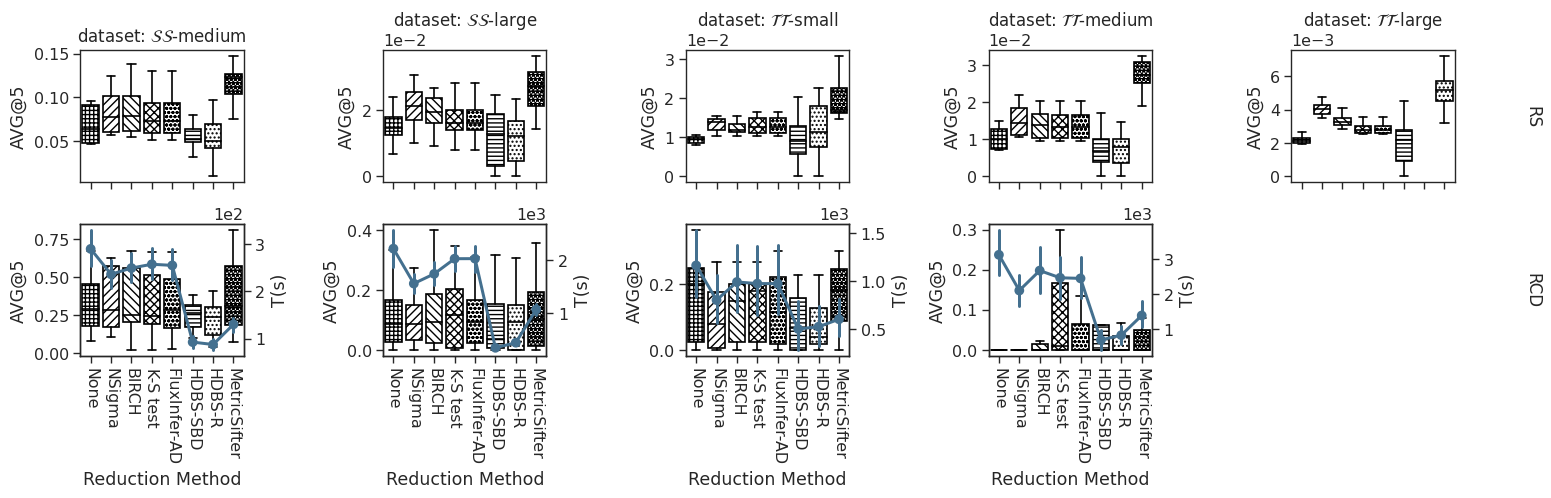

In [113]:
# remove localization methods that perform less well than RS

plot_grid(joined_df, datasets[1:], loc_methods=["RS", "RCD"], col="dataset", row="localization_method")


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


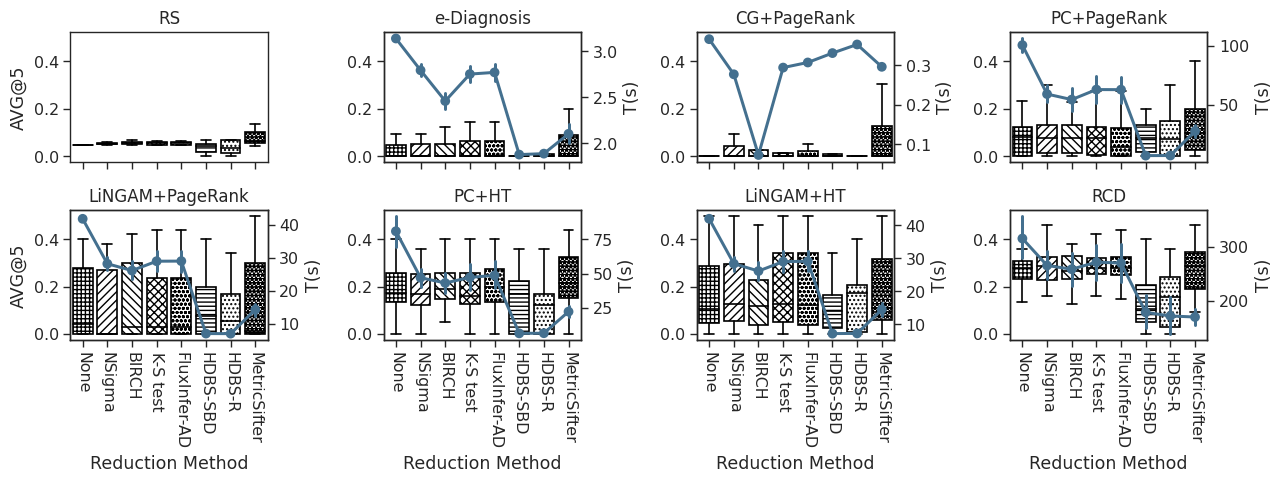

In [120]:
plot_grid_by_dataset(joined_df, "SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)


/tmp/ipykernel_2660326/722618135.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


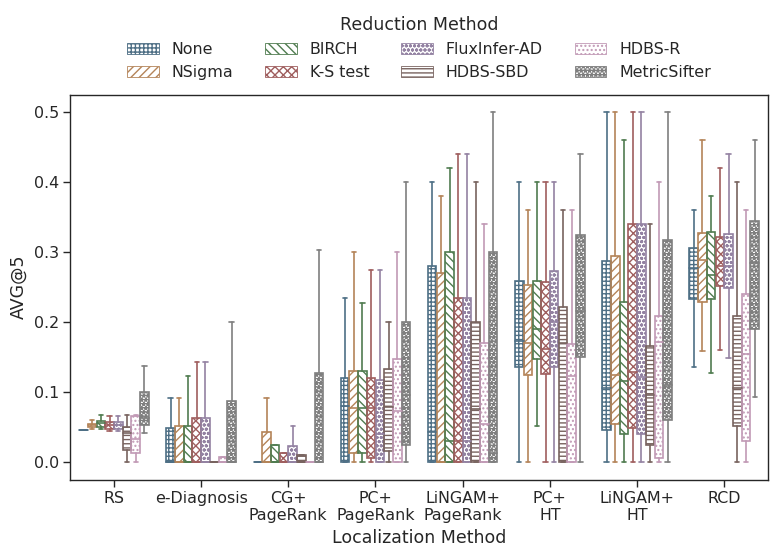

In [45]:
plot_combination(joined_df, "SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)


/tmp/ipykernel_2660326/722618135.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


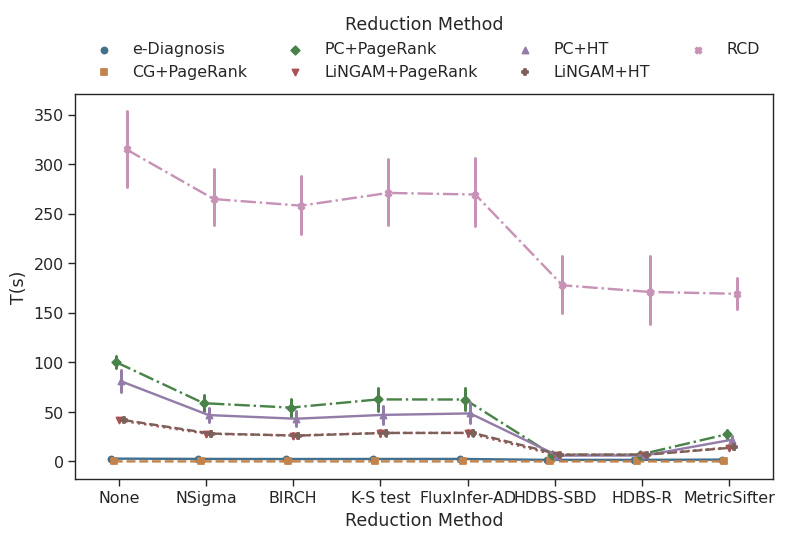

In [47]:
plot_combination(joined_df, "SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS[1:], plot_type="point")


In [ ]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)


## Ablation Study

In [50]:
# TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID = 894, 899
# TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID + 1)]
TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in {1849,1850,1767,1868,1877,1818}]


In [51]:
def convert_to_step_name(phase: str) -> str:
    match phase:
        case "phase1":
            return "STEP0"
        case "phase2":
            return "STEP0-1"
        case "phase3":
            return "STEP0-3"
        case _:
            assert False, f"Unknown phase: {phase}"

def fetch_tsdr_metadata_by_phase(run_id: str) -> list[dict[str, str|float]]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return []
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (_, _, _, _, _):
                return []
                # assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        csv_path = f"/tmp/summary_by_phase-csv-{run_id}.csv"
        run["scores/summary_by_phase-csv"].download(destination=csv_path)
        summary_by_phase = pd.read_csv(csv_path)
        items = []
        for _, row in summary_by_phase.iterrows():  # skip phase1 simple filtering
            num_series = tuple([int(s) for s in row["num_series/total"].split("/")])
            num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]

            specificity = row["cause_metrics/specificity_mean"]
            recall = row["cause_metrics/recall_mandatory_mean"]
            bacc = row["cause_metrics/bacc_mean"]
            mcc = row["cause_metrics/mcc_mean"]
            elapsed_time = row["elapsed_time"]

            items.append({
                "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                "method": convert_to_step_name(row["phase"]),
                "phase": row["phase"],
                "specificity": specificity, "recall": recall, "bacc": bacc, "mcc": mcc,
                "elapsed_time": elapsed_time,
                "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
            })
        return items


In [52]:
tsdr_phase_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_tsdr_metadata_by_phase)(run) for run in TSDR_ABLATION_RUN_IDS)
assert tsdr_phase_items is not None
tsdr_phase_items = sum(tsdr_phase_items, [])
tsdr_phase_items = [item for item in tsdr_phase_items if item]


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1868
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1850
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1818
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1877
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1868/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1818/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune

In [89]:
steps = ["STEP0", "STEP0-1", "STEP0-3"]
metrics = ["specificity", "recall", "bacc", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, steps], names=['Dataset', 'Step'],
)
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''],
)

tsdr_phase_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
    index=multi_level_indexes,
)
tsdr_phase_df["elapsed_time_sum"] = tsdr_phase_df.groupby(level=[0])["elapsed_time"].cumsum()


In [90]:
tsdr_phase_df


phase  specificity    recall      bacc        mcc  \
Dataset   Step                                                          
SS-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.120935  1.000000  0.560467  -0.583098   
          STEP0-3  phase3     0.346632  0.975000  0.660816   0.088060   
SS-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.130083  1.000000  0.565041   0.052579   
          STEP0-3  phase3     0.457775  0.979167  0.718471   0.136381   
SS-large  STEP0    phase1     0.000000  1.000000  0.500000        NaN   
          STEP0-1  phase2     0.088772  0.998437  0.543605   0.020770   
          STEP0-3  phase3     0.493700  0.941810  0.717755   0.059565   
TT-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.297582  0.928571  0.613077   0.028059   
          STEP0-3  phase3     0.548195  0.904762  0.726478   0.050718   
TT-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.251748  0.952381  0.602065   0.028104   
          STEP0-3  phase3     0.655096  0.948413  0.801754   0.073770   
TT-large  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.168255  0.976190  0.572223   0.010502   
          STEP0-3  phase3     0.650948  0.849773  0.750361   0.028442   

                   elapsed_time  num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                                 
SS-small  STEP0        0.365774                    64                     64   
          STEP0-1      1.337830                    56                     64   
          STEP0-3      0.309271                    42                     64   
SS-medium STEP0        0.376814                   185                    185   
          STEP0-1      3.006089                   162                    185   
          STEP0-3      0.403848                   102                    185   
SS-large  STEP0        0.485167                  1347                   1347   
          STEP0-1     16.659445                  1229                   1347   
          STEP0-3      1.310194                   687                   1347   
TT-small  STEP0        0.571000                   329                    329   
          STEP0-1      4.984876                   233                    329   
          STEP0-3      0.778895                   149                    329   
TT-medium STEP0        0.784019                  1250                   1250   
          STEP0-1     16.657667                   937                   1250   
          STEP0-3      1.885619                   435                   1250   
TT-large  STEP0        1.661038                  9343                   9343   
          STEP0-1     99.464219                  7779                   9343   
          STEP0-3     13.580952                  3277                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
SS-small  STEP0                  80                 1.000000  0.030802   
          STEP0-1                80                 1.000000  0.035587   
          STEP0-3                80                 0.975000  0.051296   
SS-medium STEP0                 499                 4.437500  0.047151   
          STEP0-1               499                 4.437500  0.054288   
          STEP0-3               499                 4.337500  0.088676   
SS-large  STEP0                6793                 6.800000  0.010018   
          STEP0-1              6793                 6.787500  0.010952   
          STEP0-3              6793                 6.312500  0.018531   
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.008070

In [91]:
import itertools

df_display = tsdr_phase_df[["specificity", "recall", "bacc", "elapsed_time_sum"]]
tsdr_s = df_display.style
tsdr_s.clear()
# tsdr_s.highlight_max(subset=(itertools.product(datasets, steps), ["FRR", "RFR", "RFP"]), props='textbf:--rwrap;')\
#     .highlight_min(subset=(itertools.product(datasets, steps), ["elapsed_time"]), props='textbf:--rwrap;')
tsdr_s.format({"RFP": '{:.4f}'}, precision=3)
tsdr_s.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

def highlight_max(s, props='textbf:--rwrap;'):
    is_max = s == s.max()
    return [props if v else '' for v in is_max]

def highlight_min(s, props='textbf:--rwrap;'):
    is_min = s == s.min()
    return [props if v else '' for v in is_min]

for dataset in datasets:
    tsdr_s.apply(highlight_max, subset=(itertools.product([dataset], steps), ["specificity", "recall", "bacc"]), axis=0)
    # tsdr_s.apply(highlight_min, subset=(itertools.product([dataset], steps), ["elapsed_time"]), axis=0)
print(tsdr_s.to_latex(hrules=True))


\begin{tabular}{llrrrr}
\toprule
 &  & specificity & recall & bacc & elapsed_time_sum \\
Dataset & Step &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{SS-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.366 \\
 & STEP0-1 & 0.121 & \textbf{1.000} & 0.560 & 1.704 \\
 & STEP0-3 & \textbf{0.347} & 0.975 & \textbf{0.661} & 2.013 \\
\multirow[c]{3}{*}{SS-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.377 \\
 & STEP0-1 & 0.130 & \textbf{1.000} & 0.565 & 3.383 \\
 & STEP0-3 & \textbf{0.458} & 0.979 & \textbf{0.718} & 3.787 \\
\multirow[c]{3}{*}{SS-large} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.485 \\
 & STEP0-1 & 0.089 & 0.998 & 0.544 & 17.145 \\
 & STEP0-3 & \textbf{0.494} & 0.942 & \textbf{0.718} & 18.455 \\
\multirow[c]{3}{*}{TT-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.571 \\
 & STEP0-1 & 0.298 & 0.929 & 0.613 & 5.556 \\
 & STEP0-3 & \textbf{0.548} & 0.905 & \textbf{0.726} & 6.335 \\
\multirow[c]{3}{*}{TT-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.784 \\
 & ST